<div style="
    background-color:#4f46e5;
    padding:32px;
    border-radius:16px;
    color:white;
    text-align:center;
    margin:30px 0;
">

<h1 style="
    font-size:40px;
    font-weight:900;
    margin:0 0 12px 0;
    letter-spacing:0.8px;
">
🎮 Rock–Paper–Scissors Classification
</h1>

<p style="
    font-size:18px;
    margin:10px 0 0 0;
    font-weight:500;
    text-align:center;
">
Deep Learning | CNN & Transfer Learning | PyTorch
</p>

<div style="
    margin-top:20px;
    padding:10px;
    background-color:#4338ca;
    border-radius:10px;
">
    <span style="margin:0 12px;">📊 Computer Vision</span>
    <span style="margin:0 12px;">🤖 Deep Learning</span>
    <span style="margin:0 12px;">🔁 Transfer Learning</span>
</div>

</div>


<div style="background-color:#f7f9fc; padding:24px; border-radius:12px; border-left:6px solid #667eea;">

<h2 style="color:#2d3748; margin-top:0;">
📘 Project Overview
</h2>

<p style="color:#4a5568; font-size:15px; line-height:1.7;">
This notebook presents a complete <b>end-to-end deep learning pipeline</b> for
<b>hand gesture image classification</b> using
<b>Convolutional Neural Networks (CNN)</b> and
<b>Transfer Learning</b> techniques implemented in <b>PyTorch</b>.
</p>

<hr>

<h3 style="color:#2d3748;">
🎯 Objectives
</h3>

<ul style="color:#4a5568; font-size:14.5px; line-height:1.7;">
  <li>Train a <b>custom CNN</b> from scratch as a baseline model</li>
  <li>Apply <b>Transfer Learning</b> using <b>MobileNetV2</b></li>
  <li>Compare performance between baseline CNN and pretrained models</li>
  <li>Evaluate robustness on <b>real-world phone-captured images</b></li>
</ul>

<h3 style="color:#2d3748;">
</div>

</div>


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    📦 Importing Libraries
</div>

<div style="
    background: #f7fafc;
    padding: 15px;
    border-left: 4px solid #667eea;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #4a5568; margin: 0; font-size: 14px;">
        Loading essential libraries for deep learning, data manipulation, and visualization.
    </p>
</div>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    📊 Dataset Configuration
</div>


In [3]:

DATASET_PATH = "/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/"


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🔄 Data Preprocessing & Augmentation
</div>

<div style="
    background: #fef3c7;
    padding: 20px;
    border-left: 4px solid #f59e0b;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #78350f; margin: 0 0 10px 0; font-weight: 600;">
        💡 Why Data Augmentation?
    </p>
    <p style="color: #4a5568; margin: 0; font-size: 14px; line-height: 1.6;">
        Data augmentation artificially expands the training dataset by applying random transformations. This helps the model generalize better to unseen images and reduces overfitting.
    </p>
</div>

### 🎨 Training Transform (With Augmentation)
Applies random transformations to create variations during training

In [4]:
train_transform = transforms.Compose([
    # Use RandomResizedCrop instead of Resize for scale invariance
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30), # Slightly increased rotation
    # Add Saturation and Hue to handle different lighting conditions
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.1), # robust to color shifts
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 📏 Evaluation Transform (No Augmentation)
Only resizes and normalizes - no random transformations for consistent evaluation

In [5]:
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    📂 Dataset Loading & Splitting
</div>

<div style="
    background: #e0e7ff;
    padding: 20px;
    border-left: 4px solid #6366f1;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #312e81; margin: 0 0 10px 0; font-weight: 600;">
        📊 Data Split Strategy
    </p>
    <ul style="color: #4a5568; margin: 5px 0; font-size: 14px; line-height: 1.8;">
        <li><strong>Training Set (70%):</strong> Used to train the model</li>
        <li><strong>Validation Set (15%):</strong> Used to tune hyperparameters and monitor training</li>
        <li><strong>Test Set (15%):</strong> Used for final evaluation on completely unseen data</li>
    </ul>
</div>

In [6]:
train_dataset = datasets.ImageFolder(
    root=DATASET_PATH,
    transform=train_transform
)

eval_dataset = datasets.ImageFolder(
    root=DATASET_PATH,
    transform=eval_transform
)

#### 🔀 Generate Shuffled Indices
Randomly shuffle the dataset to ensure unbiased split

In [7]:
num_samples = len(train_dataset)
indices = np.random.permutation(num_samples)

train_size = int(0.7 * num_samples)
val_size   = int(0.15 * num_samples)

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size + val_size]
test_idx  = indices[train_size + val_size:]

#### 📦 Create Dataset Subsets
Split data into training, validation, and test sets

In [8]:
train_ds = Subset(train_dataset, train_idx)
val_ds   = Subset(eval_dataset, val_idx)
test_ds  = Subset(eval_dataset, test_idx)

<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🔌 DataLoaders
</div>

<div style="
    background: #f7fafc;
    padding: 15px;
    border-left: 4px solid #667eea;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #4a5568; margin: 0; font-size: 14px;">
        DataLoaders handle batching, shuffling, and efficient data loading during training and evaluation
    </p>
</div>

In [9]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🏗️ Custom CNN Architecture
</div>

<div style="
    background: linear-gradient(135deg, #fef3c7 0%, #fde68a 100%);
    padding: 20px;
    border-left: 4px solid #f59e0b;
    border-radius: 8px;
    margin: 15px 0;
">
    <h4 style="color: #78350f; margin: 0 0 10px 0;">📐 Model Architecture</h4>
    <p style="color: #4a5568; margin: 0 0 10px 0; font-size: 14px;">
        <strong>Convolutional Layers:</strong> Extract spatial features from images
    </p>
    <ul style="color: #4a5568; margin: 5px 0 10px 20px; font-size: 13px;">
        <li>3 Conv layers with increasing filters: 32 → 64 → 128</li>
        <li>ReLU activation for non-linearity</li>
        <li>MaxPooling to reduce spatial dimensions</li>
    </ul>
    <p style="color: #4a5568; margin: 10px 0 0 0; font-size: 14px;">
        <strong>Fully Connected Layers:</strong> Perform final classification
    </p>
</div>

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [11]:
full_dataset = datasets.ImageFolder(
    root=DATASET_PATH,
    transform=train_transform
)

print("Detected classes:", full_dataset.classes)
print("Number of classes:", len(full_dataset.classes))


Detected classes: ['paper', 'rock', 'scissors']
Number of classes: 3


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    ⚙️ Training Configuration (Simple CNN)
</div>

<div style="
    background: #f7fafc;
    padding: 15px;
    border-left: 4px solid #667eea;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #4a5568; margin: 0; font-size: 14px;">
        Initialize model, loss function, and optimizer for training the custom CNN
    </p>
</div>

In [12]:
model = CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🚀 Training & Validation Loop
</div>

<div style="
    background: linear-gradient(135deg, #dbeafe 0%, #bfdbfe 100%);
    padding: 20px;
    border-left: 4px solid #3b82f6;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #1e3a8a; margin: 0 0 10px 0; font-weight: 600;">
        🔄 Training Process
    </p>
    <p style="color: #4a5568; margin: 0; font-size: 14px; line-height: 1.6;">
        The model learns by iteratively processing training batches, computing loss, and updating weights. Validation performance is monitored to detect overfitting.
    </p>
</div>

In [13]:
epochs = 10
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):

    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)


    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_loss.append(v_loss / len(val_loader))
    val_acc.append(v_correct / v_total)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc[-1]:.4f} | "
        f"Val Acc: {val_acc[-1]:.4f}"
    )

Epoch [1/10] | Train Acc: 0.3430 | Val Acc: 0.5212
Epoch [2/10] | Train Acc: 0.4711 | Val Acc: 0.7593
Epoch [3/10] | Train Acc: 0.7058 | Val Acc: 0.7566
Epoch [4/10] | Train Acc: 0.8288 | Val Acc: 0.8492
Epoch [5/10] | Train Acc: 0.8827 | Val Acc: 0.8095
Epoch [6/10] | Train Acc: 0.9019 | Val Acc: 0.9603
Epoch [7/10] | Train Acc: 0.9274 | Val Acc: 0.9259
Epoch [8/10] | Train Acc: 0.9263 | Val Acc: 0.9048
Epoch [9/10] | Train Acc: 0.9376 | Val Acc: 0.9603
Epoch [10/10] | Train Acc: 0.9512 | Val Acc: 0.9841


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    📈 Training Curves
</div>

<div style="
    background: #f7fafc;
    padding: 15px;
    border-left: 4px solid #667eea;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #4a5568; margin: 0; font-size: 14px;">
        Visualize training progress: loss and accuracy over epochs
    </p>
</div>

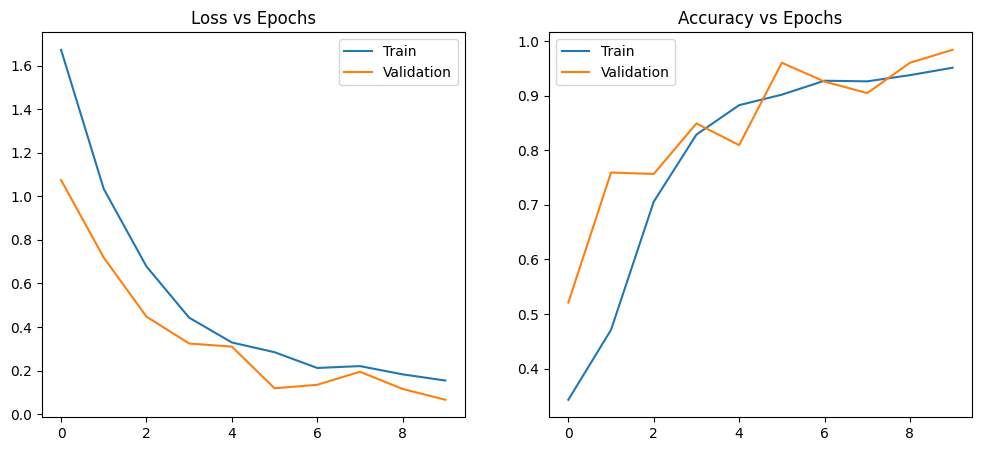

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🎯 Test Set Evaluation
</div>

<div style="
    background: #ecfdf5;
    padding: 15px;
    border-left: 4px solid #10b981;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #065f46; margin: 0; font-size: 14px;">
        Evaluate the trained model on the held-out test set to measure real-world performance
    </p>
</div>

In [15]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    🔍 Confusion Matrix
</div>

<div style="
    background: #fef3c7;
    padding: 15px;
    border-left: 4px solid #f59e0b;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #78350f; margin: 0; font-size: 14px;">
        <strong>Confusion Matrix</strong> shows where the model gets confused - revealing which classes are misclassified
    </p>
</div>

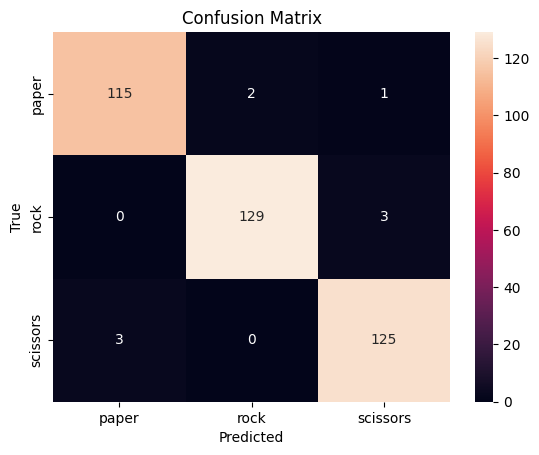

In [16]:

class_names = train_dataset.classes
NUM_CLASSES = len(class_names)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    📊 Classification Report
</div>

<div style="
    background: #f7fafc;
    padding: 15px;
    border-left: 4px solid #667eea;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #4a5568; margin: 0; font-size: 14px;">
        Detailed metrics: <strong>Precision</strong>, <strong>Recall</strong>, <strong>F1-Score</strong> for each class
    </p>
</div>

In [17]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

       paper       0.97      0.97      0.97       118
        rock       0.98      0.98      0.98       132
    scissors       0.97      0.98      0.97       128

    accuracy                           0.98       378
   macro avg       0.98      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378



<div style="
    background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    display: inline-block;
">
    👁️ Visual Error Analysis
</div>

<div style="
    background: #fef2f2;
    padding: 15px;
    border-left: 4px solid #ef4444;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #7f1d1d; margin: 0; font-size: 14px;">
        Visualize misclassified images to understand model weaknesses and improve future iterations
    </p>
</div>

In [18]:
errors = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                errors.append((images[i], labels[i], preds[i]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6330532..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16505454..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.670168..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.722689..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6330532..2.64].


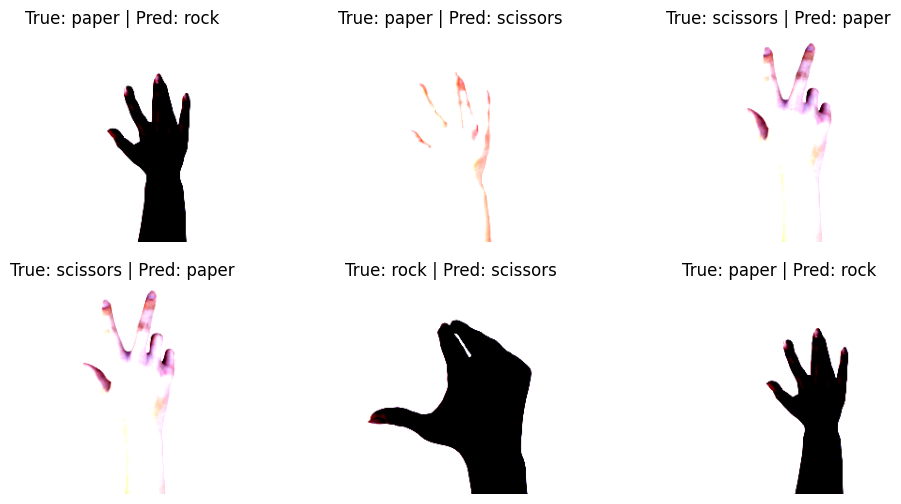

In [19]:
plt.figure(figsize=(12,6))

for i in range(min(6, len(errors))):
    img, true, pred = errors[i]
    img = img.permute(1,2,0).cpu()

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true]} | Pred: {class_names[pred]}")
    plt.axis("off")

plt.show()


<div style="background-color:#f9fafb; padding:24px; border-radius:12px; border:2px solid #9ca3af; margin:30px 0;">

<h2 style="color:#1f2937; margin:0 0 18px 0; text-align:center;">
📋 Simple CNN – Summary
</h2>

<div style="background-color:#ffffff; padding:18px; border-radius:10px; margin:14px 0; border-left:5px solid #10b981;">
<h3 style="color:#059669; margin:0 0 8px 0;">✅ Strengths</h3>
<ul style="color:#4a5568; font-size:14.5px; line-height:1.7;">
  <li>Performs well on <b>controlled dataset images</b></li>
  <li>Fast training due to simple architecture</li>
  <li>Provides a strong baseline for comparison</li>
</ul>
</div>

<div style="background-color:#ffffff; padding:18px; border-radius:10px; margin:14px 0; border-left:5px solid #dc2626;">
<h3 style="color:#dc2626; margin:0 0 8px 0;">⚠️ Limitations</h3>
<ul style="color:#4a5568; font-size:14.5px; line-height:1.7;">
  <li>Struggles with <b>real-world phone images</b></li>
  <li>Sensitive to lighting variations</li>
  <li>Poor generalization across backgrounds</li>
  <li>Affected by camera angle and quality</li>
  <li>Requires large labeled datasets</li>
</ul>
</div>

<div style="background-color:#059669; color:white; padding:14px; border-radius:8px; margin-top:18px; text-align:center; font-weight:700;">
💡 Solution: Use Transfer Learning for better performance
</div>

</div>


<div style="
    background: linear-gradient(135deg, #10b981 0%, #059669 100%);
    padding: 50px;
    border-radius: 20px;
    color: white;
    text-align: center;
    box-shadow: 0 15px 50px rgba(16, 185, 129, 0.4);
    margin: 50px 0;
    border: 3px solid #34d399;
">
    <h1 style="
        font-size: 52px;
        font-weight: 900;
        margin: 0 0 15px 0;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
    ">
        🚀 Transfer Learning Approach
    </h1>
    <p style="
        font-size: 22px;
        margin: 15px 0;
        opacity: 0.95;
        font-weight: 600;
    ">
        Leveraging Pre-trained MobileNetV2 for Superior Performance
    </p>
    <div style="
        margin-top: 25px;
        padding: 18px;
        background: rgba(255,255,255,0.15);
        border-radius: 12px;
        display: inline-block;
    ">
        <span style="margin: 0 18px; font-size: 16px;">⚡ Optimized</span>
        <span style="margin: 0 18px; font-size: 16px;">🎯 Fine-Tuning</span>
        <span style="margin: 0 18px; font-size: 16px;">⚡ Real-World Ready</span>
    </div>
</div>

<div style="background-color:#059669; color:white; padding:16px; border-radius:10px; font-size:24px; font-weight:700; margin:28px 0; text-align:center;">
🧠 Why Transfer Learning?
</div>

<div style="background-color:#ecfdf5; padding:24px; border-left:6px solid #10b981; border-radius:12px; margin:20px 0;">

<h3 style="color:#065f46; margin:0 0 12px 0;">🎯 Core Concept</h3>
<p style="color:#374151; font-size:15px; line-height:1.7; margin:0 0 18px 0;">
Transfer Learning leverages models pre-trained on <b>millions of images (ImageNet: 14M+)</b>
to extract rich visual features. Instead of training from scratch, we adapt this
learned knowledge to our specific hand gesture classification task.
</p>

<hr>

<h3 style="color:#065f46; margin:18px 0 12px 0;">✨ Key Advantages</h3>

<div style="background-color:#ffffff; padding:14px; border-radius:8px; margin:10px 0; border-left:4px solid #10b981;">
<b>🎨 Superior Feature Extraction</b><br>
<span style="color:#4b5563; font-size:14px;">
Learns edges, textures, and complex patterns from diverse images
</span>
</div>

<div style="background-color:#ffffff; padding:14px; border-radius:8px; margin:10px 0; border-left:4px solid #10b981;">
<b>📊 Less Data Required</b><br>
<span style="color:#4b5563; font-size:14px;">
Achieves high accuracy even with limited training samples
</span>
</div>

<div style="background-color:#ffffff; padding:14px; border-radius:8px; margin:10px 0; border-left:4px solid #10b981;">
<b>🌍 Better Generalization</b><br>
<span style="color:#4b5563; font-size:14px;">
Robust to lighting changes, background clutter, and camera angles
</span>
</div>

<div style="background-color:#ffffff; padding:14px; border-radius:8px; margin:10px 0; border-left:4px solid #10b981;">
<b>⚡ Faster Training</b><br>
<span style="color:#4b5563; font-size:14px;">
Only final layers are fine-tuned, leading to faster convergence
</span>
</div>

<hr>

<h3 style="color:#065f46; margin:20px 0 12px 0;">📱 Why MobileNetV2?</h3>
<ul style="color:#374151; font-size:14.5px; line-height:1.7; padding-left:18px;">
  <li><b>Mobile-first design</b> – optimized for edge & phone deployment</li>
  <li><b>Lightweight & efficient</b> – fast inference with low compute cost</li>
  <li><b>High accuracy</b> – strong ImageNet performance</li>
  <li><b>Production-ready</b> – widely used in real-world applications</li>
</ul>

</div>


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    📥 Load Pre-trained MobileNetV2
</div>

<div style="
    background: #ecfdf5;
    padding: 20px;
    border-left: 4px solid #10b981;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #065f46; margin: 0 0 10px 0; font-weight: 600;">
        🔧 Transfer Learning Strategy
    </p>
    <ol style="color: #4a5568; font-size: 14px; line-height: 1.8; margin: 5px 0;">
        <li><strong>Load pre-trained MobileNetV2</strong> (trained on ImageNet)</li>
        <li><strong>Freeze backbone layers</strong> (retain learned features)</li>
        <li><strong>Replace classifier head</strong> (adapt to our 3 classes)</li>
        <li><strong>Train only the classifier</strong> (fast convergence)</li>
    </ol>
</div>

In [20]:
from torchvision import models
import torch.nn as nn

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet.parameters():
    param.requires_grad = False

# Number of classes
num_classes = len(class_names)

# Get number of input features from MobileNet
num_features = mobilenet.classifier[1].in_features  # = 1280


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 129MB/s]


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    ⚙️ Training Configuration (Transfer Learning)
</div>

<div style="
    background: #fef3c7;
    padding: 15px;
    border-left: 4px solid #f59e0b;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #78350f; margin: 0; font-size: 14px;">
        Configure optimizer and learning rate scheduler for efficient fine-tuning
    </p>
</div>

In [21]:

# Replace classifier
mobilenet.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, num_classes)
)

# Move to device
mobilenet = mobilenet.to(device)

print("MobileNetV2 loaded successfully!")
print(f"Number of features: {num_features}")
print(f"Output classes: {num_classes} (Rock, Paper, Scissors)")


MobileNetV2 loaded successfully!
Number of features: 1280
Output classes: 3 (Rock, Paper, Scissors)


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    🚀 Feature Extraction (Transfer Learning)
</div>



In [22]:
criterion_tl = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_tl = torch.optim.AdamW(
    mobilenet.classifier.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tl,
    mode="max",
    factor=0.5,
    patience=2
)

scaler = torch.cuda.amp.GradScaler()

print("Training configuration ready!")


Training configuration ready!


/tmp/ipykernel_24/3465786533.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    🚀 Train and Validation
</div>



In [23]:
epochs = 10
train_loss_tl, train_acc_tl = [], []
val_loss_tl, val_acc_tl = [], []

print("\n Starting Improved Transfer Learning...\n")

for epoch in range(epochs):
    # ---- TRAIN ----
    mobilenet.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        optimizer_tl.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = mobilenet(images)
            loss = criterion_tl(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(mobilenet.parameters(), 1.0)
        scaler.step(optimizer_tl)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss_tl.append(running_loss / len(train_loader))
    train_acc_tl.append(correct / total)

    # ---- VALIDATION ----
    mobilenet.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = mobilenet(images)
            loss = criterion_tl(outputs, labels)

            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_loss_tl.append(v_loss / len(val_loader))
    val_acc_tl.append(v_correct / v_total)

    scheduler.step(val_acc_tl[-1])

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc_tl[-1]:.4f} | "
        f"Val Acc: {val_acc_tl[-1]:.4f}"
    )

    # ---- PROGRESSIVE UNFREEZE ----
    if epoch == 4:
        print("Unfreezing last MobileNet blocks...")
        for param in mobilenet.features[-2:].parameters():
            param.requires_grad = True

        optimizer_tl = torch.optim.AdamW(
            mobilenet.parameters(), lr=1e-4, weight_decay=1e-4
        )

print("\n Improved Transfer Learning Complete!")



 Starting Improved Transfer Learning...



/tmp/ipykernel_24/2147144716.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] | Train Acc: 0.6740 | Val Acc: 0.9630
Epoch [2/10] | Train Acc: 0.9110 | Val Acc: 0.9788
Epoch [3/10] | Train Acc: 0.9495 | Val Acc: 0.9974
Epoch [4/10] | Train Acc: 0.9467 | Val Acc: 0.9921
Epoch [5/10] | Train Acc: 0.9683 | Val Acc: 0.9868
Unfreezing last MobileNet blocks...
Epoch [6/10] | Train Acc: 0.9632 | Val Acc: 0.9815
Epoch [7/10] | Train Acc: 0.9790 | Val Acc: 0.9974
Epoch [8/10] | Train Acc: 0.9887 | Val Acc: 1.0000
Epoch [9/10] | Train Acc: 0.9887 | Val Acc: 1.0000
Epoch [10/10] | Train Acc: 0.9853 | Val Acc: 0.9894

 Improved Transfer Learning Complete!


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    📊 Performance Comparison
</div>

<div style="
    background: linear-gradient(135deg, #fff7ed 0%, #fed7aa 100%);
    padding: 20px;
    border-left: 4px solid #f97316;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #7c2d12; margin: 0; font-weight: 600; font-size: 15px;">
        🔍 Side-by-Side Analysis
    </p>
    <p style="color: #4a5568; margin: 5px 0 0 0; font-size: 14px;">
        Compare training and validation accuracy curves between Simple CNN and Transfer Learning approaches
    </p>
</div>

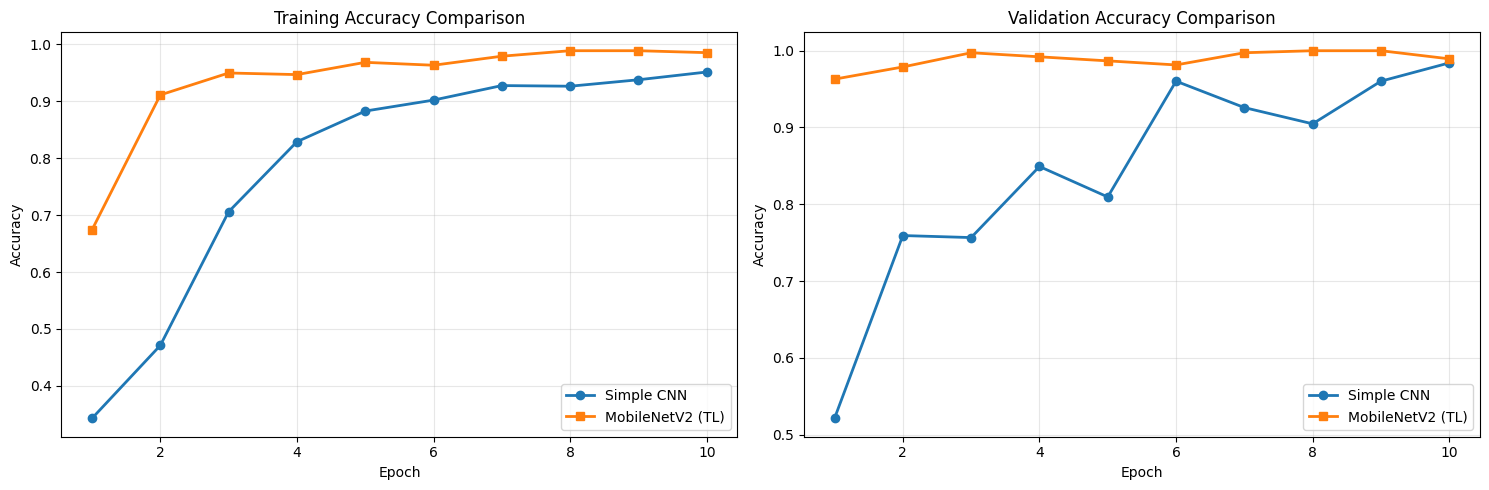


 Final Results
Simple CNN - Val Accuracy: 0.9841
Transfer Learning - Val Accuracy: 0.9894
Improvement: 0.53%


In [24]:

# Use correct epoch ranges for each model
epochs_cnn = np.arange(1, len(train_acc) + 1)
epochs_tl  = np.arange(1, len(train_acc_tl) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ---- Training Accuracy ----
axes[0].plot(
    epochs_cnn, train_acc,
    label="Simple CNN", marker="o", linewidth=2
)
axes[0].plot(
    epochs_tl, train_acc_tl,
    label="MobileNetV2 (TL)", marker="s", linewidth=2
)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training Accuracy Comparison")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---- Validation Accuracy ----
axes[1].plot(
    epochs_cnn, val_acc,
    label="Simple CNN", marker="o", linewidth=2
)
axes[1].plot(
    epochs_tl, val_acc_tl,
    label="MobileNetV2 (TL)", marker="s", linewidth=2
)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy Comparison")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Final Results ----
print("\n Final Results")
print(f"Simple CNN - Val Accuracy: {val_acc[-1]:.4f}")
print(f"Transfer Learning - Val Accuracy: {val_acc_tl[-1]:.4f}")
print(f"Improvement: {(val_acc_tl[-1] - val_acc[-1]) * 100:.2f}%")


<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    📱 Real-World Phone Images Test
</div>

<div style="
    background: linear-gradient(135deg, #fef2f2 0%, #fecaca 100%);
    padding: 20px;
    border-left: 4px solid #dc2626;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #7f1d1d; margin: 0 0 10px 0; font-weight: 600; font-size: 15px;">
        🎯 The Ultimate Test
    </p>
    <p style="color: #4a5568; margin: 0; font-size: 14px; line-height: 1.6;">
        Test both models on actual phone camera images to evaluate real-world performance. This reveals the true capability gap between simple CNN and transfer learning.
    </p>
</div>

In [25]:
import glob
# Load phone images (update path to your phone images folder)
phone_image_path = "/kaggle/input/rps-test/Real_test"

# Get all image files
phone_images = glob.glob(f"{phone_image_path}*/*.jpg") + glob.glob(f"{phone_image_path}*/*.png")

if len(phone_images) == 0:
    print(" No phone images found. Update the phone_image_path variable.")
else:
    print(f"Found {len(phone_images)} phone images for testing")

Found 7 phone images for testing


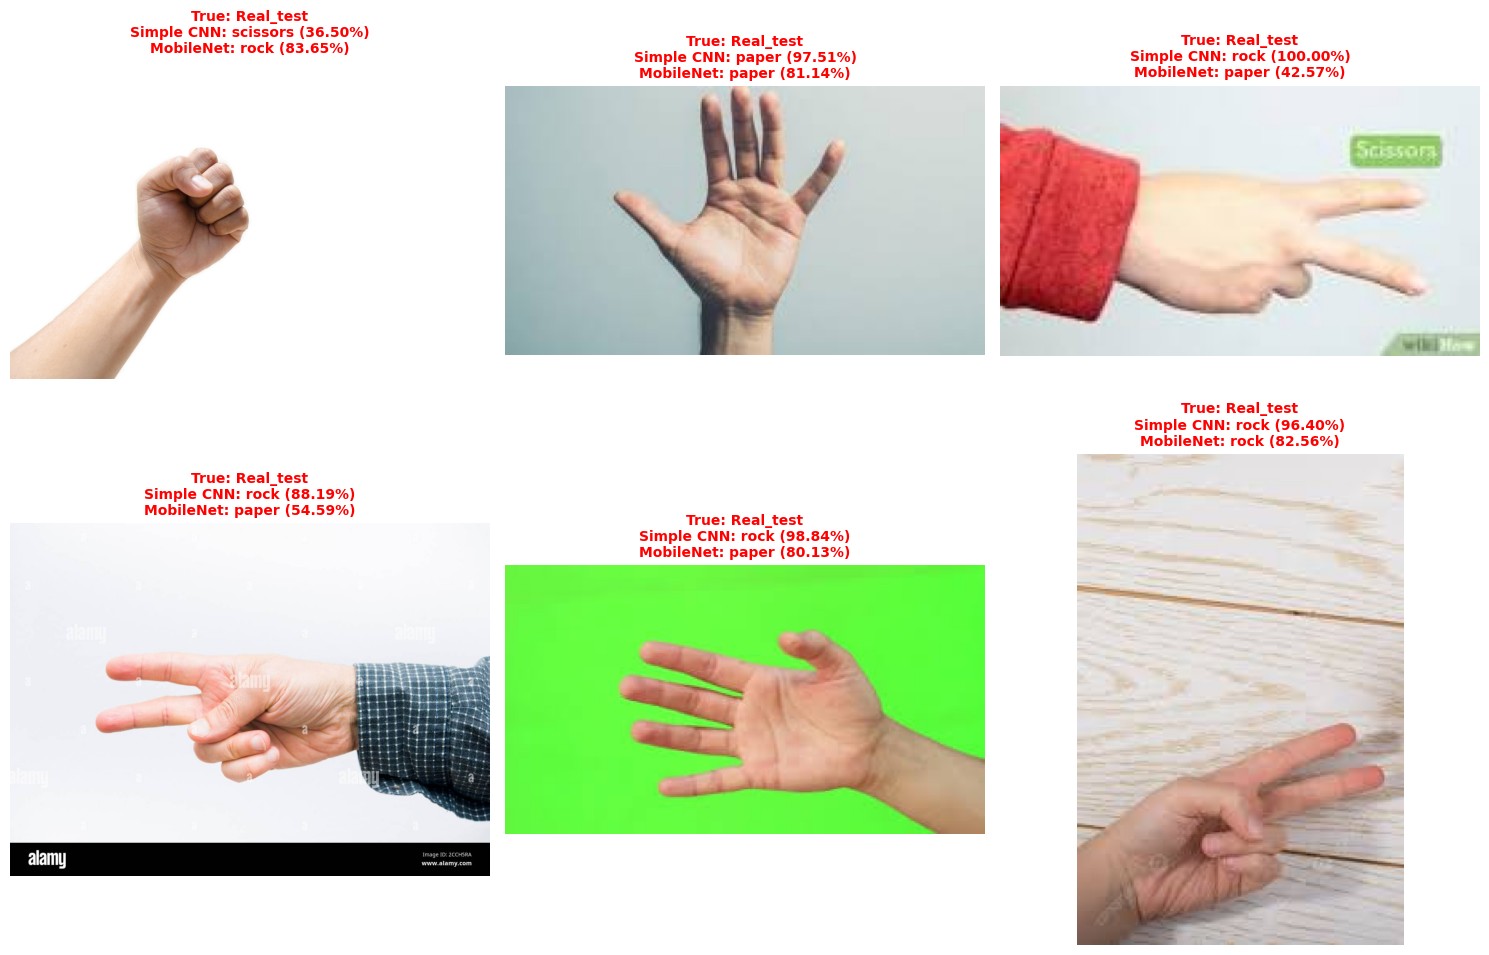

In [26]:
from PIL import Image
def predict_image(model, image_path, transform, class_names):
    """Predict a single image using the model"""
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return class_names[predicted.item()], confidence.item(), image

# Test on a few phone images
if len(phone_images) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    class_names = ['paper', 'rock', 'scissors']  # Update based on your dataset
    
    for idx, img_path in enumerate(phone_images[:6]):  # Show first 6 images
        # Predict with both models
        pred_cnn, conf_cnn, img = predict_image(model, img_path, eval_transform, class_names)
        pred_tl, conf_tl, _ = predict_image(mobilenet, img_path, eval_transform, class_names)
        
        # Get true label from folder name
        true_label = img_path.split('/')[-2]
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"True: {true_label}\n"
            f"Simple CNN: {pred_cnn} ({conf_cnn:.2%})\n"
            f"MobileNet: {pred_tl} ({conf_tl:.2%})",
            fontsize=10,
            fontweight='bold',
            color='green' if pred_tl == true_label else 'red'
        )
    
    plt.tight_layout()
    plt.show()
else:
    print("Add phone images to test real-world performance!")

<div style="
    background: linear-gradient(90deg, #10b981 0%, #059669 100%);
    color: white;
    padding: 20px 30px;
    border-radius: 12px;
    font-size: 26px;
    font-weight: 700;
    margin: 30px 0 20px 0;
    box-shadow: 0 4px 15px rgba(16, 185, 129, 0.4);
    display: inline-block;
">
    💾 Save Trained Model
</div>

<div style="
    background: #ecfdf5;
    padding: 15px;
    border-left: 4px solid #10b981;
    border-radius: 8px;
    margin: 15px 0;
">
    <p style="color: #065f46; margin: 0; font-size: 14px;">
        Save the fine-tuned model for deployment and future inference
    </p>
</div>

In [27]:
# Save the fine-tuned model
torch.save(mobilenet.state_dict(), 'rps_mobilenetv2.pth')
print(" Model saved as 'rps_mobilenetv2.pth'")



 Model saved as 'rps_mobilenetv2.pth'


<div style="background-color:#059669; padding:28px; border-radius:14px; color:white; margin:40px 0;">

<h2 style="margin:0 0 22px 0; font-size:30px; text-align:center; font-weight:800;">
🎯 Final Summary & Recommendations
</h2>

<div style="background-color:#ecfdf5; padding:20px; border-radius:12px; margin:18px 0; color:#1f2937; border-left:6px solid #10b981;">

<h3 style="color:#065f46; margin:0 0 14px 0;">📊 Approach Comparison</h3>

<div style="background-color:#ffffff; padding:16px; border-radius:10px; margin:12px 0; border-left:5px solid #dc2626;">
<h4 style="color:#dc2626; margin:0 0 8px 0;">Simple CNN (Baseline)</h4>
<ul style="font-size:14px; line-height:1.7; padding-left:18px; margin:0;">
  <li>Performs well in <b>controlled environments</b></li>
  <li>Useful for learning CNN fundamentals</li>
  <li>Struggles with <b>real-world phone images</b></li>
  <li>Sensitive to lighting and background changes</li>
  <li>Requires large datasets and longer training</li>
  <li>Poor generalization to unseen environments</li>
</ul>
</div>

<div style="background-color:#ffffff; padding:16px; border-radius:10px; margin:12px 0; border-left:5px solid #059669;">
<h4 style="color:#059669; margin:0 0 8px 0;">Transfer Learning with MobileNetV2 (Recommended)</h4>
<ul style="font-size:14px; line-height:1.7; padding-left:18px; margin:0;">
  <li><b>Excellent performance</b> on real-world images</li>
  <li>Pre-trained on 14M+ ImageNet images</li>
  <li>Robust to lighting, background, and angle variations</li>
  <li>Faster convergence with fewer epochs</li>
  <li>High accuracy with less training data</li>
  <li>Production-ready and mobile-optimized</li>
</ul>
</div>

</div>

<div style="background-color:#047857; padding:18px; border-radius:12px; margin-top:20px; text-align:center;">
<h3 style="margin:0 0 10px 0; font-size:22px;">💡 Professional Recommendation</h3>
<p style="font-size:15.5px; line-height:1.7; margin:0;">
For <b>production deployment</b> and <b>real-world applications</b>, especially with phone cameras,
<b>Transfer Learning using MobileNetV2</b> is strongly recommended due to its robustness,
efficiency, and superior generalization.
</p>
</div>

</div>
